### This notebook looks at the impact of systematically deleting SC ... to the OUTER networks i.e., from ntwx A to ntwx B, C, etc

#### In this notebook (based on the convo with "Dave"), I try to isolate the different FC NTwx, but strcuturally. 
##### I will then run whobpyt on these structurally isolated ntwx to see how it affects FC, potentially shedding some light on how FC ntwx emerge. 

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be first attempted for a single subject.  
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
from collections import Counter

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
import pickle

In [5]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [6]:
import re

In [7]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [8]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [9]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [10]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 59.3 s, sys: 668 ms, total: 1min
Wall time: 1min 9s


In [11]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.51 s, sys: 130 ms, total: 1.64 s
Wall time: 1.64 s


In [12]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [13]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [14]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
# all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
# all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
# all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
# all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
# all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
# all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
# all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
#     all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
#     all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
#     all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
#     all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
#     all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
#     all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
#     all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 2min 33s, sys: 3.89 s, total: 2min 37s
Wall time: 6min 37s


In [15]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_sommot_lesion,
                        all_subs_dorsattn_lesion,all_subs_ventattn_lesion,
                        all_subs_limbic_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

In [16]:
# for now deal with avg fc of DMN lesion only (across all ntwx) ...
# This is OUTER connectivity ... i.e., the average ntwx conn to other ntwx (so Vis to SomMot, DorsAttn, ..., DMN etc)

# all_subs_og_whobpyt
# all_subs_dmn_lesion

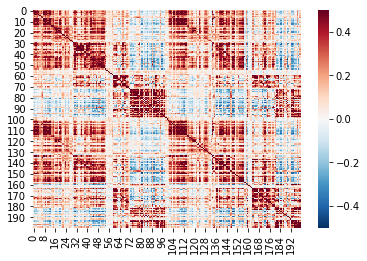

In [17]:
sns.heatmap(all_subs_emp_fc_mat[99], cmap='RdBu_r',center=0,vmax=0.5)

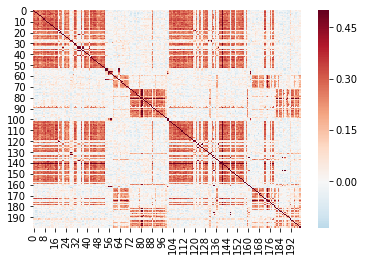

In [18]:
sns.heatmap(all_subs_og_whobpyt[99], cmap='RdBu_r',center=0,vmax=0.5)

In [19]:
i = 99

print(np.corrcoef(all_subs_og_whobpyt[i][mask], all_subs_emp_fc_mat[i][mask])[0][1])

0.6288580771510476


In [20]:
from numpy.polynomial.polynomial import polyfit

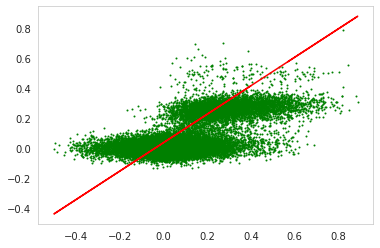

In [21]:
rww_test = all_subs_og_whobpyt[99][mask].flatten()

rww_test2 = all_subs_emp_fc_mat[99][mask].flatten()

m, b = np.polyfit(rww_test, rww_test2, 1)

sns.set_style('whitegrid')
fig,ax = plt.subplots()
plt.scatter(rww_test2, rww_test, color='green',s=1)
plt.plot(rww_test2, m*rww_test2 + b, color='red')
plt.grid(visible=False)

plt.show()

In [22]:
# for i in range(10):
#     print(np.corrcoef(all_subs_og_whobpyt[i][mask], all_subs_emp_fc_mat[i][mask])[0][1])

In [23]:
# for i in range(10):
#     rww_test = all_subs_og_whobpyt[i][mask].flatten()

#     rww_test2 = all_subs_emp_fc_mat[i][mask].flatten()

#     m, b = np.polyfit(rww_test, rww_test2, 1)

#     sns.set_style('whitegrid')
#     fig,ax = plt.subplots()
#     plt.scatter(rww_test2, rww_test, color='green',s=1)
#     plt.plot(rww_test2, m*rww_test2 + b, color='red')
#     plt.grid(visible=False)

#     plt.show()

In [24]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [25]:
# corrs_list

In [26]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [27]:
# vis --> (0,14,100,115)
# sommot --> (14,30,115,134)
# dorsattn --> (30,43,134,147)
# ventattn --> (43,54,147,158)
# limbic --> (54,60,158,164)
# fpn --> (60,73,164,181)
# dmn --> (73,100,181,200)

In [75]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

#### divide by 2

In [320]:
def outer_ntwx_only_fc(fc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_fc = ((np.mean(lh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))/2 + (np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis))/2)
    mean_ntwx_to_sommot_fc = ((np.mean(lh_ntwx_to_lh_sommot) + np.mean(rh_ntwx_to_rh_sommot))/2 + (np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot))/2)
    mean_ntwx_to_dorsattn_fc = ((np.mean(lh_ntwx_to_lh_dorsattn) + np.mean(rh_ntwx_to_rh_dorsattn))/2 + (np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn))/2)
    mean_ntwx_to_ventattn_fc = ((np.mean(lh_ntwx_to_lh_ventattn) + np.mean(rh_ntwx_to_rh_ventattn))/2 + (np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn))/2)
    mean_ntwx_to_limbic_fc = ((np.mean(lh_ntwx_to_lh_limbic) + np.mean(rh_ntwx_to_rh_limbic))/2 + (np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic))/2)
    mean_ntwx_to_fpn_fc = ((np.mean(lh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))/2 + (np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn))/2)
    mean_ntwx_to_dmn_fc = ((np.mean(lh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))/2 + (np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn))/2)
    
    
    return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
    
#     if num == 0:
#         return mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 1:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 2:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 3:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 4:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 5:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_dmn_fc
#     elif num == 6:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc

#### divide by 4

In [310]:
# def outer_ntwx_only_fc(fc, sub, num):
    
#     a, b, c, d = ntwx_labels_idxs[num]
    
#     lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
#     lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    
#     lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
#     lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    
#     lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
#     lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    
#     lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
#     lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    
#     lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
#     lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    
#     lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
#     lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    
#     lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
#     lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    
#     # ---------------------------------------------
    
#     rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
#     rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    
#     rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
#     rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    
#     rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
#     rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    
#     rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
#     rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    
#     rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
#     rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    
#     rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
#     rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    
#     rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
#     rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
        
#     mean_ntwx_to_vis_fc = (np.mean(lh_ntwx_to_lh_vis) + np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))#/4
#     mean_ntwx_to_sommot_fc = (np.mean(lh_ntwx_to_lh_sommot) + np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot) + np.mean(rh_ntwx_to_rh_sommot))#/4
#     mean_ntwx_to_dorsattn_fc = (np.mean(lh_ntwx_to_lh_dorsattn) + np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn) + np.mean(rh_ntwx_to_rh_dorsattn))#/4
#     mean_ntwx_to_ventattn_fc = (np.mean(lh_ntwx_to_lh_ventattn) + np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn) + np.mean(rh_ntwx_to_rh_ventattn))#/4
#     mean_ntwx_to_limbic_fc = (np.mean(lh_ntwx_to_lh_limbic) + np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic) + np.mean(rh_ntwx_to_rh_limbic))#/4
#     mean_ntwx_to_fpn_fc = (np.mean(lh_ntwx_to_lh_fpn) + np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))#/4
#     mean_ntwx_to_dmn_fc = (np.mean(lh_ntwx_to_lh_dmn) + np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))#/4
    
    
#     return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
    
# #     if num == 0:
# #         return mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
# #     elif num == 1:
# #         return mean_ntwx_to_vis_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
# #     elif num == 2:
# #         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
# #     elif num == 3:
# #         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
# #     elif num == 4:
# #         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
# #     elif num == 5:
# #         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_dmn_fc
# #     elif num == 6:
# #         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc

### empirical data

In [321]:
%%time

empirical_vis_to_other_ntwx = []
empirical_sommot_to_other_ntwx = []
empirical_dorsattn_to_other_ntwx = []
empirical_ventattn_to_other_ntwx = []
empirical_limbic_to_other_ntwx = []
empirical_fpn_to_other_ntwx = []
empirical_dmn_to_other_ntwx = []

for i in range(200):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,0)
    empirical_vis_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,1)
    empirical_sommot_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,2)
    empirical_dorsattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,3)
    empirical_ventattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,4)
    empirical_limbic_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,5)
    empirical_fpn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_emp_fc_mat,i,6)
    empirical_dmn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

CPU times: user 858 ms, sys: 2.02 ms, total: 860 ms
Wall time: 851 ms


In [322]:
empirical_vis_to_other_ntwx = np.mean(empirical_vis_to_other_ntwx,axis=0)
empirical_sommot_to_other_ntwx = np.mean(empirical_sommot_to_other_ntwx,axis=0)
empirical_dorsattn_to_other_ntwx = np.mean(empirical_dorsattn_to_other_ntwx,axis=0)
empirical_ventattn_to_other_ntwx = np.mean(empirical_ventattn_to_other_ntwx,axis=0)
empirical_limbic_to_other_ntwx = np.mean(empirical_limbic_to_other_ntwx,axis=0)
empirical_fpn_to_other_ntwx = np.mean(empirical_fpn_to_other_ntwx,axis=0)
empirical_dmn_to_other_ntwx = np.mean(empirical_dmn_to_other_ntwx,axis=0)

In [323]:
# Across all 200 subs
empirical_outer_to_other_ntwx  = [empirical_vis_to_other_ntwx,empirical_sommot_to_other_ntwx,
                                   empirical_dorsattn_to_other_ntwx,empirical_ventattn_to_other_ntwx,
                                   empirical_limbic_to_other_ntwx,empirical_fpn_to_other_ntwx,
                                   empirical_dmn_to_other_ntwx]

### original WhoBPyT

In [324]:
%%time

all_subs_vis_to_other_ntwx = []
all_subs_sommot_to_other_ntwx = []
all_subs_dorsattn_to_other_ntwx = []
all_subs_ventattn_to_other_ntwx = []
all_subs_limbic_to_other_ntwx = []
all_subs_fpn_to_other_ntwx = []
all_subs_dmn_to_other_ntwx = []

for i in range(200):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,0)
    all_subs_vis_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,1)
    all_subs_sommot_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,2)
    all_subs_dorsattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,3)
    all_subs_ventattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,4)
    all_subs_limbic_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,5)
    all_subs_fpn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,6)
    all_subs_dmn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

CPU times: user 874 ms, sys: 0 ns, total: 874 ms
Wall time: 865 ms


In [325]:
og_whobpyt_vis_to_other_ntwx = np.mean(all_subs_vis_to_other_ntwx,axis=0)
og_whobpyt_sommot_to_other_ntwx = np.mean(all_subs_sommot_to_other_ntwx,axis=0)
og_whobpyt_dorsattn_to_other_ntwx = np.mean(all_subs_dorsattn_to_other_ntwx,axis=0)
og_whobpyt_ventattn_to_other_ntwx = np.mean(all_subs_ventattn_to_other_ntwx,axis=0)
og_whobpyt_limbic_to_other_ntwx = np.mean(all_subs_limbic_to_other_ntwx,axis=0)
og_whobpyt_fpn_to_other_ntwx = np.mean(all_subs_fpn_to_other_ntwx,axis=0)
og_whobpyt_dmn_to_other_ntwx = np.mean(all_subs_dmn_to_other_ntwx,axis=0)

In [326]:
og_whobpyt_vis_to_other_ntwx_std = np.std(all_subs_vis_to_other_ntwx,axis=0)
og_whobpyt_sommot_to_other_ntwx_std = np.std(all_subs_sommot_to_other_ntwx,axis=0)
og_whobpyt_dorsattn_to_other_ntwx_std = np.std(all_subs_dorsattn_to_other_ntwx,axis=0)
og_whobpyt_ventattn_to_other_ntwx_std = np.std(all_subs_ventattn_to_other_ntwx,axis=0)
og_whobpyt_limbic_to_other_ntwx_std = np.std(all_subs_limbic_to_other_ntwx,axis=0)
og_whobpyt_fpn_to_other_ntwx_std = np.std(all_subs_fpn_to_other_ntwx,axis=0)
og_whobpyt_dmn_to_other_ntwx_std = np.std(all_subs_dmn_to_other_ntwx,axis=0)

In [327]:
# Across all 200 subs
og_whobpyt_outer_to_other_ntwx  = [og_whobpyt_vis_to_other_ntwx,og_whobpyt_sommot_to_other_ntwx,
                                   og_whobpyt_dorsattn_to_other_ntwx,og_whobpyt_ventattn_to_other_ntwx,
                                   og_whobpyt_limbic_to_other_ntwx,og_whobpyt_fpn_to_other_ntwx,
                                   og_whobpyt_dmn_to_other_ntwx]

In [328]:
og_whobpyt_outer_to_other_ntwx_std = [og_whobpyt_vis_to_other_ntwx_std,og_whobpyt_sommot_to_other_ntwx_std,
                                      og_whobpyt_dorsattn_to_other_ntwx_std,og_whobpyt_ventattn_to_other_ntwx_std,
                                      og_whobpyt_limbic_to_other_ntwx_std,og_whobpyt_fpn_to_other_ntwx_std,
                                      og_whobpyt_dmn_to_other_ntwx_std]

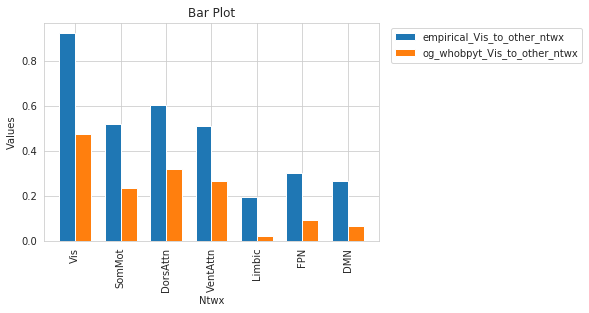

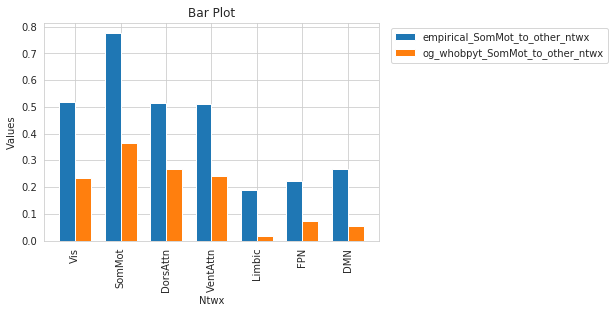

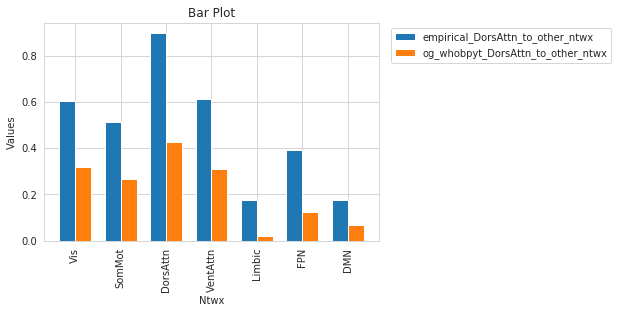

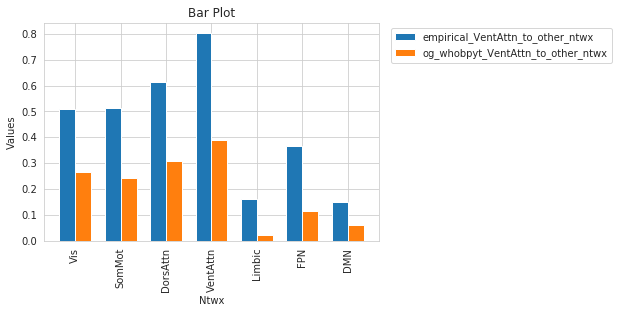

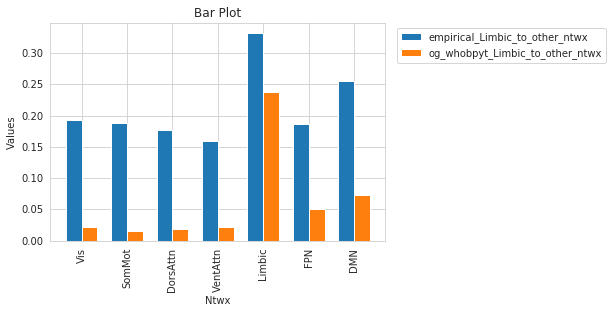

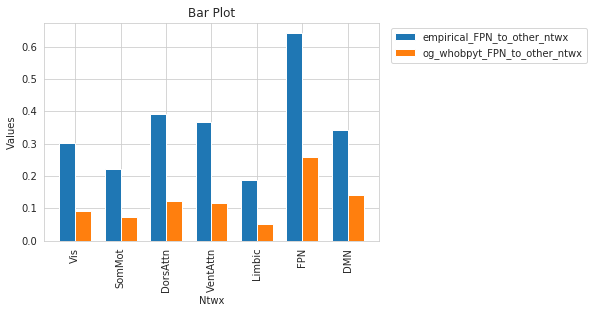

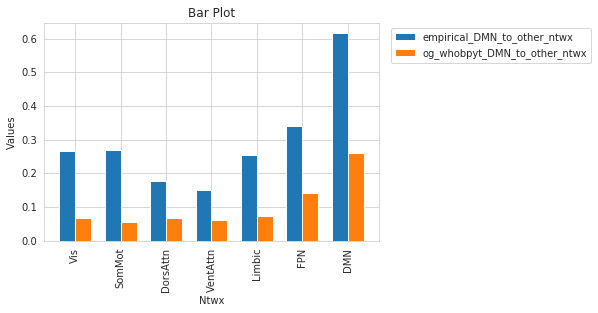

In [329]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, empirical_outer_to_other_ntwx[j], width, label='empirical_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], og_whobpyt_outer_to_other_ntwx[j], width, label='og_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

### Lesion WhoBPyT

In [330]:
def get_outer_ntwx_fc(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_sommot_to_other_ntwx_lesions = np.mean(all_subs_sommot_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dorsattn_to_other_ntwx_lesions = np.mean(all_subs_dorsattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_ventattn_to_other_ntwx_lesions = np.mean(all_subs_ventattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_limbic_to_other_ntwx_lesions = np.mean(all_subs_limbic_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_sommot_to_other_ntwx_lesions,mean_all_subs_dorsattn_to_other_ntwx_lesions,mean_all_subs_ventattn_to_other_ntwx_lesions,mean_all_subs_limbic_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [331]:
def get_outer_ntwx_fc_std(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    std_all_subs_vis_to_other_ntwx_lesions = np.std(all_subs_vis_to_other_ntwx_lesions,axis=0)
    std_all_subs_sommot_to_other_ntwx_lesions = np.std(all_subs_sommot_to_other_ntwx_lesions,axis=0)
    std_all_subs_dorsattn_to_other_ntwx_lesions = np.std(all_subs_dorsattn_to_other_ntwx_lesions,axis=0)
    std_all_subs_ventattn_to_other_ntwx_lesions = np.std(all_subs_ventattn_to_other_ntwx_lesions,axis=0)
    std_all_subs_limbic_to_other_ntwx_lesions = np.std(all_subs_limbic_to_other_ntwx_lesions,axis=0)
    std_all_subs_fpn_to_other_ntwx_lesions = np.std(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    std_all_subs_dmn_to_other_ntwx_lesions = np.std(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return std_all_subs_vis_to_other_ntwx_lesions,std_all_subs_sommot_to_other_ntwx_lesions,std_all_subs_dorsattn_to_other_ntwx_lesions,std_all_subs_ventattn_to_other_ntwx_lesions,std_all_subs_limbic_to_other_ntwx_lesions,std_all_subs_fpn_to_other_ntwx_lesions,std_all_subs_dmn_to_other_ntwx_lesions

In [332]:
def get_outer_ntwx_fc_all_subs(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    return all_subs_vis_to_other_ntwx_lesions,all_subs_sommot_to_other_ntwx_lesions,all_subs_dorsattn_to_other_ntwx_lesions,all_subs_ventattn_to_other_ntwx_lesions,all_subs_limbic_to_other_ntwx_lesions,all_subs_fpn_to_other_ntwx_lesions,all_subs_dmn_to_other_ntwx_lesions

In [333]:
len(all_subs_vis_lesion)

200

# Mean

In [334]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_vis_lesion)

sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_sommot_lesion)

dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dorsattn_lesion)

ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_ventattn_lesion)

limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_limbic_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dmn_lesion)


CPU times: user 5.75 s, sys: 6.13 ms, total: 5.76 s
Wall time: 5.74 s


In [335]:
vis_lesion_outer_to_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [336]:
og_whobpyt_outer_to_other_ntwx = [arr.tolist() for arr in og_whobpyt_outer_to_other_ntwx]


vis_lesion_outer_to_other_ntwx = [arr.tolist() for arr in vis_lesion_outer_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [arr.tolist() for arr in sommot_lesion_outer_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dorsattn_lesion_outer_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in ventattn_lesion_outer_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [arr.tolist() for arr in limbic_lesion_outer_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in fpn_lesion_outer_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dmn_lesion_outer_to_other_ntwx]

# Standard Deviation

In [337]:
vis_lesion_std_vis_to_other_ntwx, vis_lesion_std_sommot_to_other_ntwx, vis_lesion_std_dorsattn_to_other_ntwx, vis_lesion_std_ventattn_to_other_ntwx, vis_lesion_std_limbic_to_other_ntwx, vis_lesion_std_fpn_to_other_ntwx, vis_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_vis_lesion)

sommot_lesion_std_vis_to_other_ntwx, sommot_lesion_std_sommot_to_other_ntwx, sommot_lesion_std_dorsattn_to_other_ntwx, sommot_lesion_std_ventattn_to_other_ntwx, sommot_lesion_std_limbic_to_other_ntwx, sommot_lesion_std_fpn_to_other_ntwx, sommot_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_sommot_lesion)

dorsattn_lesion_std_vis_to_other_ntwx, dorsattn_lesion_std_sommot_to_other_ntwx, dorsattn_lesion_std_dorsattn_to_other_ntwx, dorsattn_lesion_std_ventattn_to_other_ntwx, dorsattn_lesion_std_limbic_to_other_ntwx, dorsattn_lesion_std_fpn_to_other_ntwx, dorsattn_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_dorsattn_lesion)

ventattn_lesion_std_vis_to_other_ntwx, ventattn_lesion_std_sommot_to_other_ntwx, ventattn_lesion_std_dorsattn_to_other_ntwx, ventattn_lesion_std_ventattn_to_other_ntwx, ventattn_lesion_std_limbic_to_other_ntwx, ventattn_lesion_std_fpn_to_other_ntwx, ventattn_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_ventattn_lesion)

limbic_lesion_std_vis_to_other_ntwx, limbic_lesion_std_sommot_to_other_ntwx, limbic_lesion_std_dorsattn_to_other_ntwx, limbic_lesion_std_ventattn_to_other_ntwx, limbic_lesion_std_limbic_to_other_ntwx, limbic_lesion_std_fpn_to_other_ntwx, limbic_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_limbic_lesion)

fpn_lesion_std_vis_to_other_ntwx, fpn_lesion_std_sommot_to_other_ntwx, fpn_lesion_std_dorsattn_to_other_ntwx, fpn_lesion_std_ventattn_to_other_ntwx, fpn_lesion_std_limbic_to_other_ntwx, fpn_lesion_std_fpn_to_other_ntwx, fpn_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_fpn_lesion)

dmn_lesion_std_vis_to_other_ntwx, dmn_lesion_std_sommot_to_other_ntwx, dmn_lesion_std_dorsattn_to_other_ntwx, dmn_lesion_std_ventattn_to_other_ntwx, dmn_lesion_std_limbic_to_other_ntwx, dmn_lesion_std_fpn_to_other_ntwx, dmn_lesion_std_dmn_to_other_ntwx = get_outer_ntwx_fc_std(all_subs_dmn_lesion)

In [338]:
vis_lesion_std_outer_to_other_ntwx = [vis_lesion_std_vis_to_other_ntwx, vis_lesion_std_sommot_to_other_ntwx, vis_lesion_std_dorsattn_to_other_ntwx, vis_lesion_std_ventattn_to_other_ntwx, vis_lesion_std_limbic_to_other_ntwx, vis_lesion_std_fpn_to_other_ntwx, vis_lesion_std_dmn_to_other_ntwx]
sommot_lesion_std_outer_to_other_ntwx = [sommot_lesion_std_vis_to_other_ntwx, sommot_lesion_std_sommot_to_other_ntwx, sommot_lesion_std_dorsattn_to_other_ntwx, sommot_lesion_std_ventattn_to_other_ntwx, sommot_lesion_std_limbic_to_other_ntwx, sommot_lesion_std_fpn_to_other_ntwx, sommot_lesion_std_dmn_to_other_ntwx]
dorsattn_lesion_std_outer_to_other_ntwx = [dorsattn_lesion_std_vis_to_other_ntwx, dorsattn_lesion_std_sommot_to_other_ntwx, dorsattn_lesion_std_dorsattn_to_other_ntwx, dorsattn_lesion_std_ventattn_to_other_ntwx, dorsattn_lesion_std_limbic_to_other_ntwx, dorsattn_lesion_std_fpn_to_other_ntwx, dorsattn_lesion_std_dmn_to_other_ntwx]
ventattn_lesion_std_outer_to_other_ntwx = [ventattn_lesion_std_vis_to_other_ntwx, ventattn_lesion_std_sommot_to_other_ntwx, ventattn_lesion_std_dorsattn_to_other_ntwx, ventattn_lesion_std_ventattn_to_other_ntwx, ventattn_lesion_std_limbic_to_other_ntwx, ventattn_lesion_std_fpn_to_other_ntwx, ventattn_lesion_std_dmn_to_other_ntwx]
limbic_lesion_std_outer_to_other_ntwx = [limbic_lesion_std_vis_to_other_ntwx, limbic_lesion_std_sommot_to_other_ntwx, limbic_lesion_std_dorsattn_to_other_ntwx, limbic_lesion_std_ventattn_to_other_ntwx, limbic_lesion_std_limbic_to_other_ntwx, limbic_lesion_std_fpn_to_other_ntwx, limbic_lesion_std_dmn_to_other_ntwx]
fpn_lesion_std_outer_to_other_ntwx = [fpn_lesion_std_vis_to_other_ntwx, fpn_lesion_std_sommot_to_other_ntwx, fpn_lesion_std_dorsattn_to_other_ntwx, fpn_lesion_std_ventattn_to_other_ntwx, fpn_lesion_std_limbic_to_other_ntwx, fpn_lesion_std_fpn_to_other_ntwx, fpn_lesion_std_dmn_to_other_ntwx]
dmn_lesion_std_outer_to_other_ntwx = [dmn_lesion_std_vis_to_other_ntwx, dmn_lesion_std_sommot_to_other_ntwx, dmn_lesion_std_dorsattn_to_other_ntwx, dmn_lesion_std_ventattn_to_other_ntwx, dmn_lesion_std_limbic_to_other_ntwx, dmn_lesion_std_fpn_to_other_ntwx, dmn_lesion_std_dmn_to_other_ntwx]

In [339]:
og_whobpyt_outer_to_other_ntwx_std = [arr.tolist() for arr in og_whobpyt_outer_to_other_ntwx_std]


vis_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in vis_lesion_std_outer_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in sommot_lesion_std_outer_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in dorsattn_lesion_std_outer_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in ventattn_lesion_std_outer_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in limbic_lesion_std_outer_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in fpn_lesion_std_outer_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx_std = [arr.tolist() for arr in dmn_lesion_std_outer_to_other_ntwx]

In [370]:
# og_whobpyt_outer_to_other_ntwx_std

### ------------------------------------------------------------------------------------------

In [341]:
%%time

# For stats

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_vis_lesion)

smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_sommot_lesion)

dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_dorsattn_lesion)

van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_ventattn_lesion)

lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_limbic_lesion)

fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_fpn_lesion)

dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_dmn_lesion)


CPU times: user 5.69 s, sys: 0 ns, total: 5.69 s
Wall time: 5.67 s


In [342]:
og_whobpyt_all_subs_vis_to_other_ntwx, og_whobpyt_all_subs_smt_to_other_ntwx, og_whobpyt_all_subs_dan_to_other_ntwx, og_whobpyt_all_subs_van_to_other_ntwx, og_whobpyt_all_subs_lim_to_other_ntwx, og_whobpyt_all_subs_fpn_to_other_ntwx, og_whobpyt_all_subs_dmn_to_other_ntwx = get_outer_ntwx_fc_all_subs(all_subs_og_whobpyt)


In [343]:
# For stats

In [344]:
og_whobpyt_all_subs_outer_to_other_ntwx = [og_whobpyt_all_subs_vis_to_other_ntwx, og_whobpyt_all_subs_smt_to_other_ntwx, og_whobpyt_all_subs_dan_to_other_ntwx, og_whobpyt_all_subs_van_to_other_ntwx, og_whobpyt_all_subs_lim_to_other_ntwx, og_whobpyt_all_subs_fpn_to_other_ntwx, og_whobpyt_all_subs_dmn_to_other_ntwx]

vis_lesion_all_subs_outer_to_other_ntwx = [vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx]
smt_lesion_all_subs_outer_to_other_ntwx = [smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx]
dan_lesion_all_subs_outer_to_other_ntwx = [dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx]
van_lesion_all_subs_outer_to_other_ntwx = [van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx]
lim_lesion_all_subs_outer_to_other_ntwx = [lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx]
fpn_lesion_all_subs_outer_to_other_ntwx = [fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx]
dmn_lesion_all_subs_outer_to_other_ntwx = [dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx]

In [345]:
# for i in range(7):
#     print(_var_temp[i][i][i])

In [346]:
_var = [og_whobpyt_outer_to_other_ntwx,
vis_lesion_outer_to_other_ntwx,
sommot_lesion_outer_to_other_ntwx,
dorsattn_lesion_outer_to_other_ntwx,
ventattn_lesion_outer_to_other_ntwx,
limbic_lesion_outer_to_other_ntwx,
fpn_lesion_outer_to_other_ntwx,
dmn_lesion_outer_to_other_ntwx]

In [347]:
data = _var.copy()

In [348]:
len(og_whobpyt_outer_to_other_ntwx)

7

In [349]:
og_whobpyt_outer_to_other_ntwx[0]

[0.4762078600105418,
 0.23502393592845336,
 0.31940538914399746,
 0.26419179984912267,
 0.02151951489669688,
 0.09249199426094475,
 0.06632744219515917]

In [350]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

#### Visual

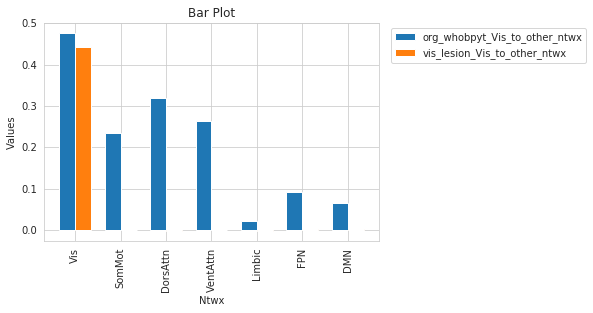

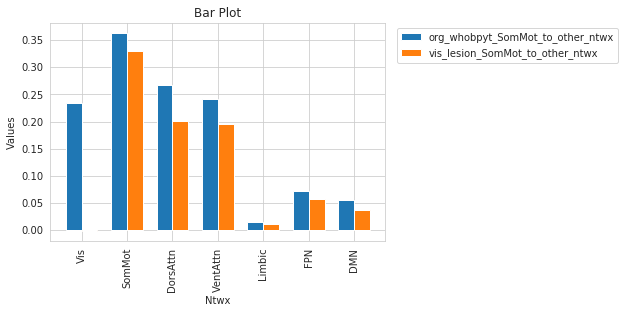

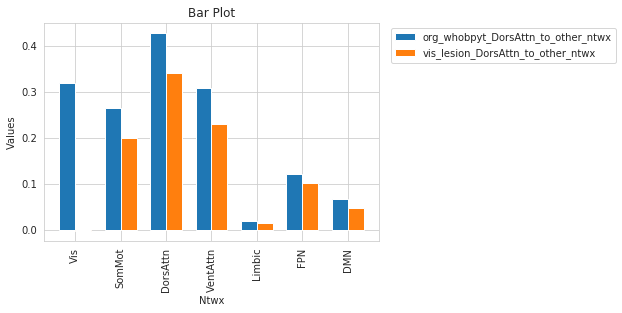

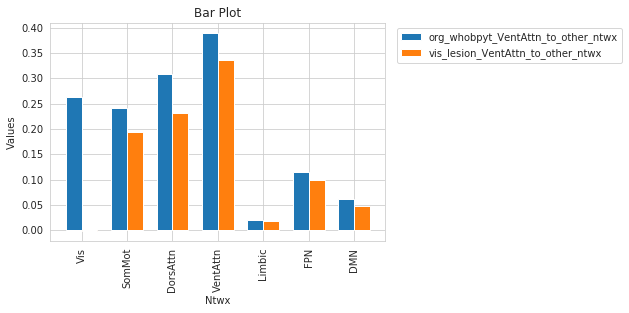

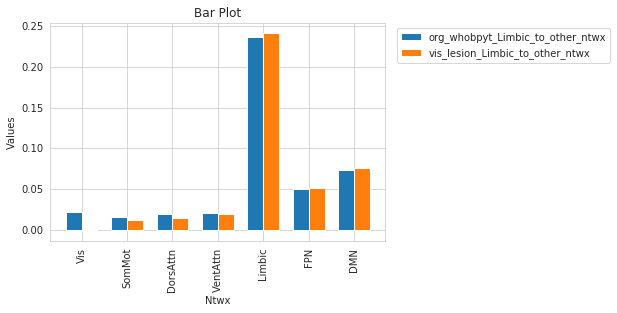

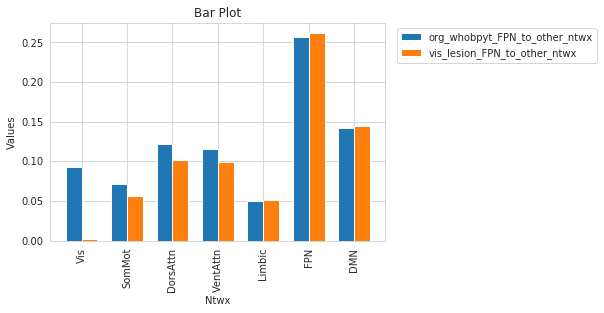

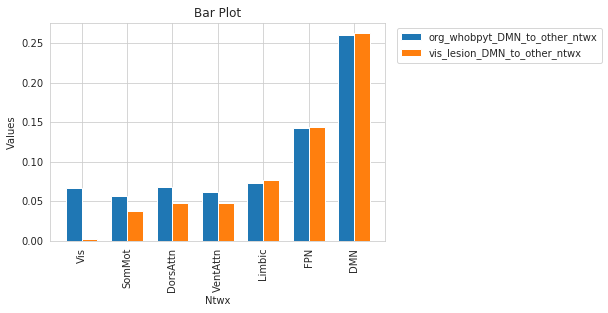

In [351]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], vis_lesion_outer_to_other_ntwx[j], width, label='vis_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### SomMot

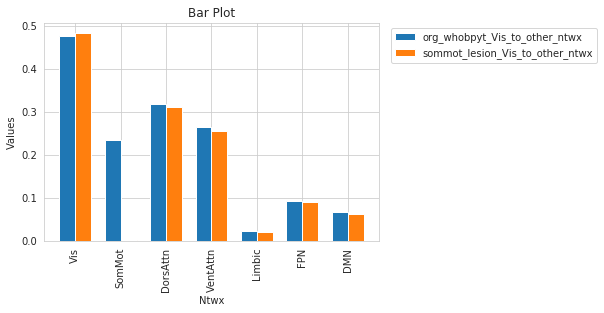

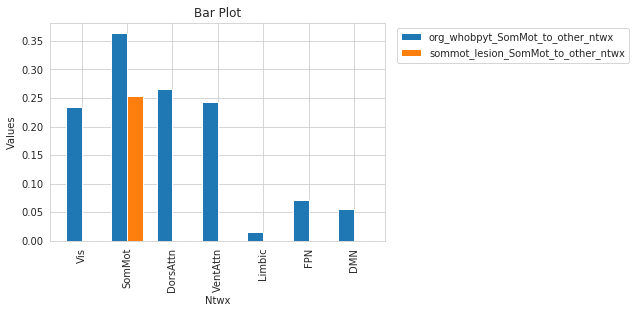

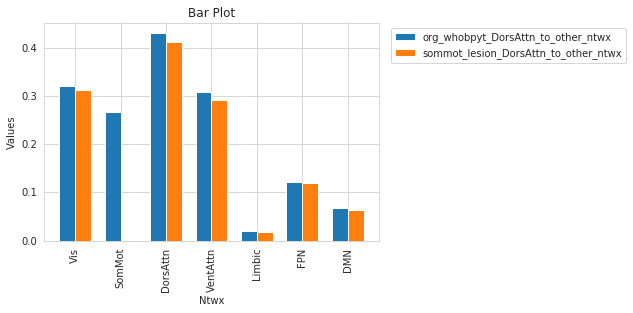

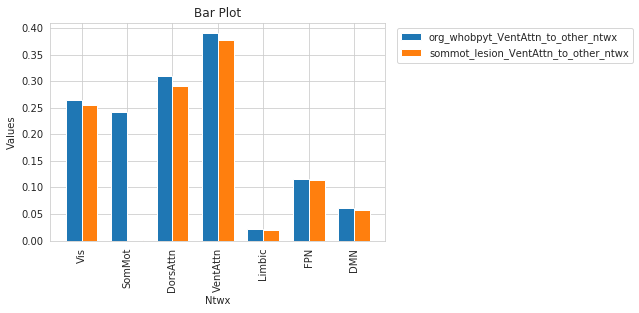

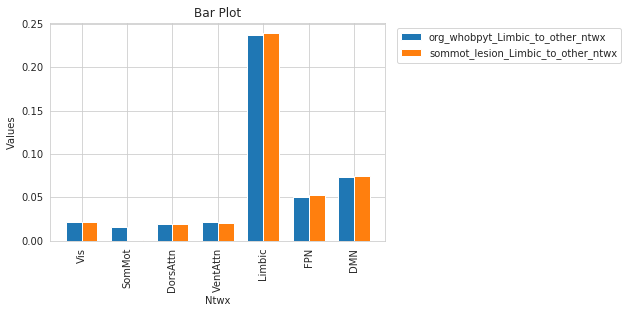

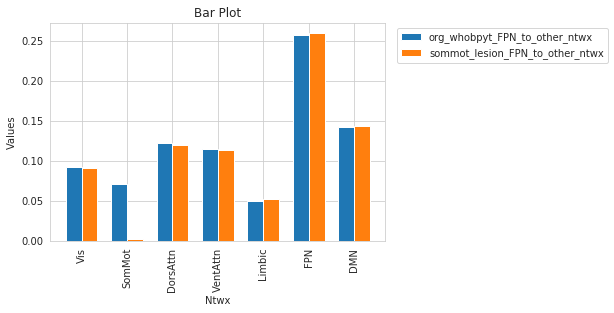

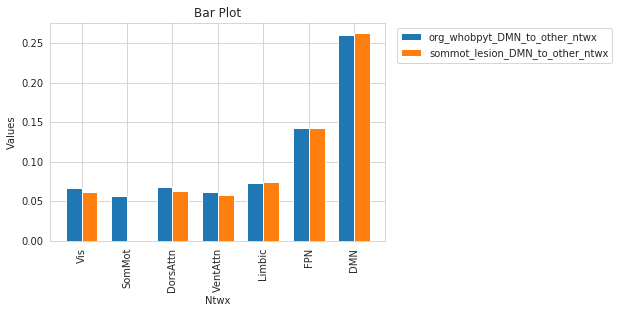

In [352]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], sommot_lesion_outer_to_other_ntwx[j], width, label='sommot_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DorsAttn

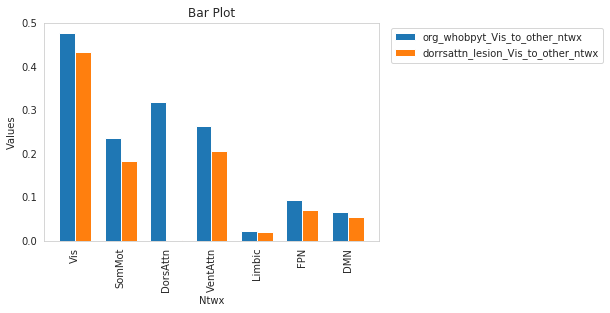

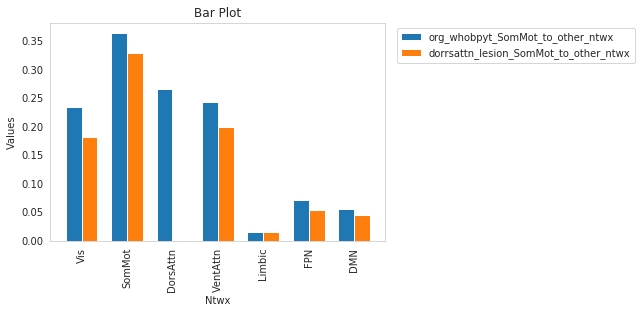

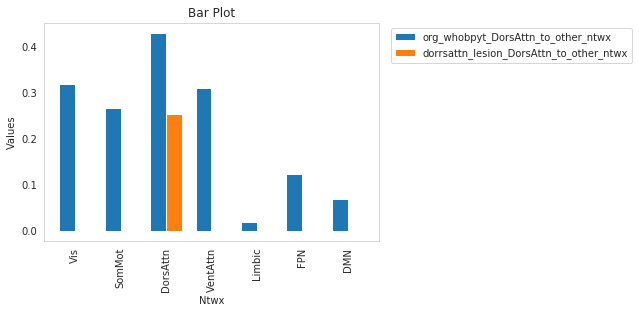

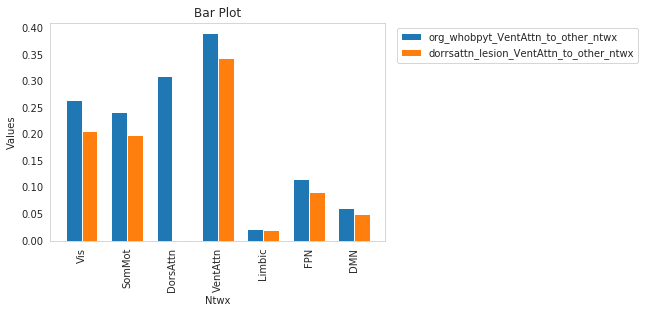

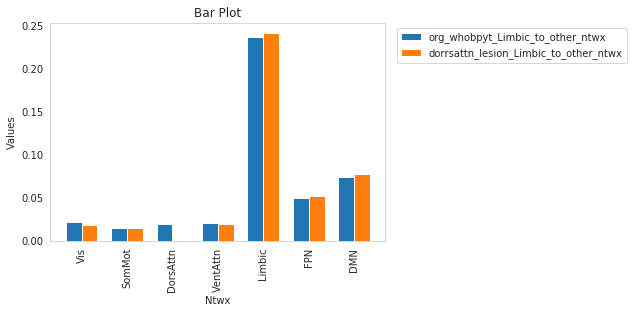

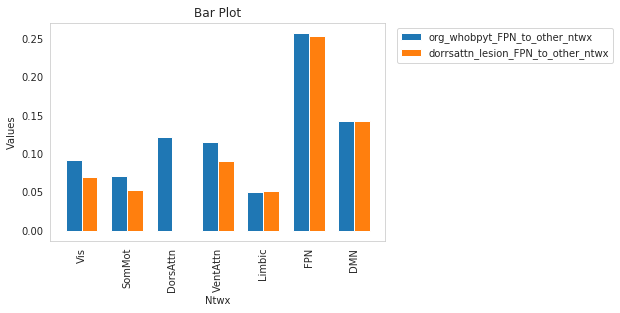

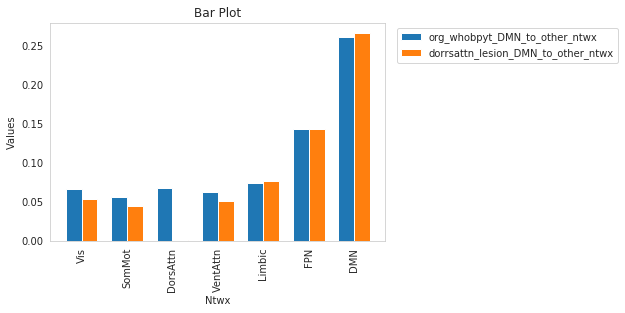

In [353]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dorsattn_lesion_outer_to_other_ntwx[j], width, label='dorrsattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.grid(False)
    
    # Displaying the plot
    plt.show()

In [354]:
# og_whobpyt_outer_to_other_ntwx

#### VentAttn

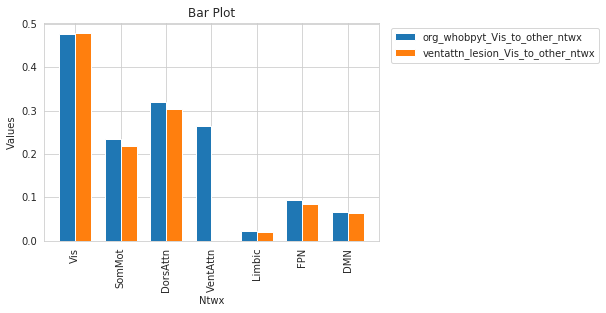

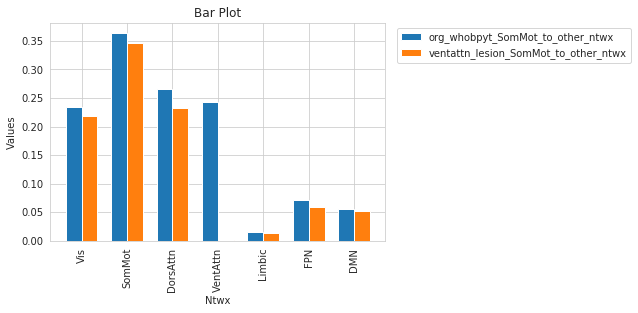

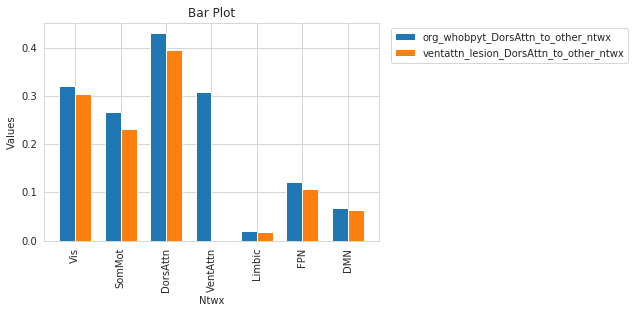

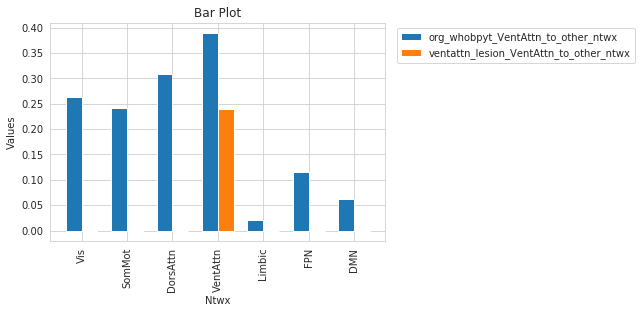

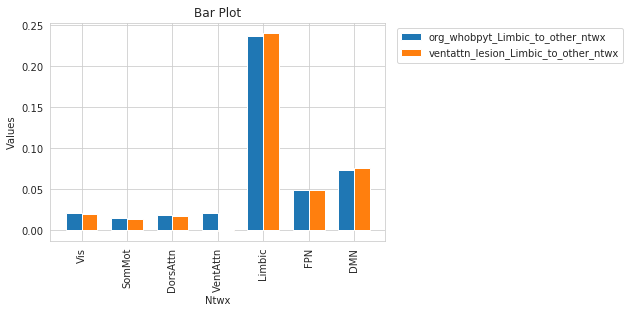

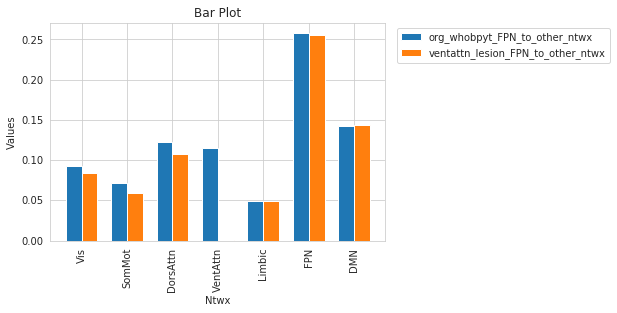

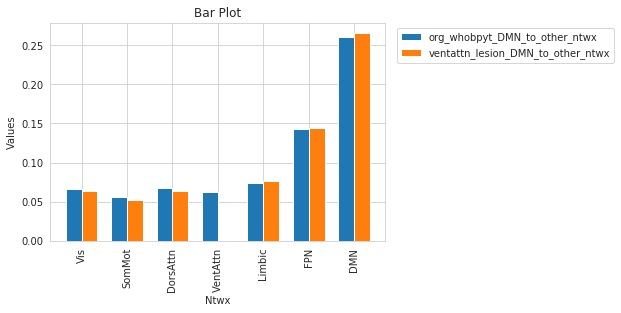

In [355]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], ventattn_lesion_outer_to_other_ntwx[j], width, label='ventattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### Limbic

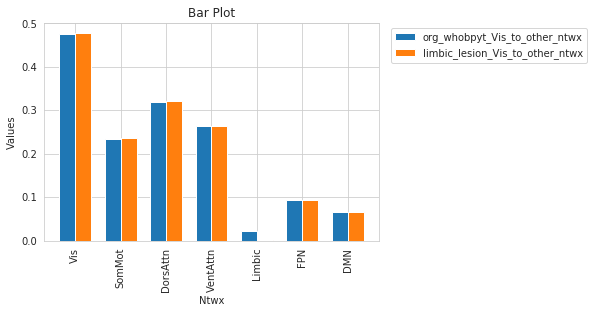

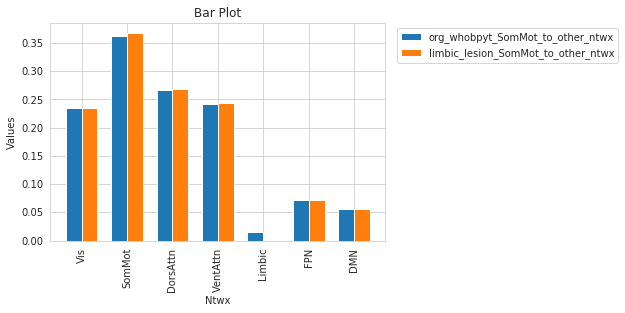

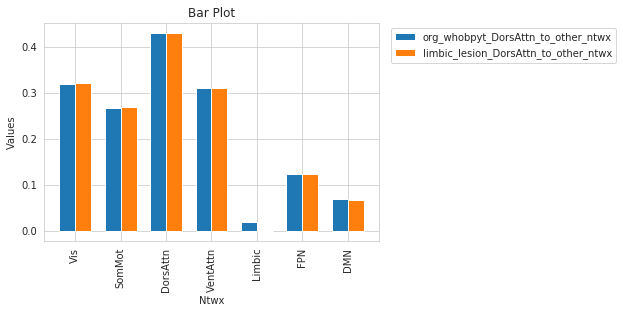

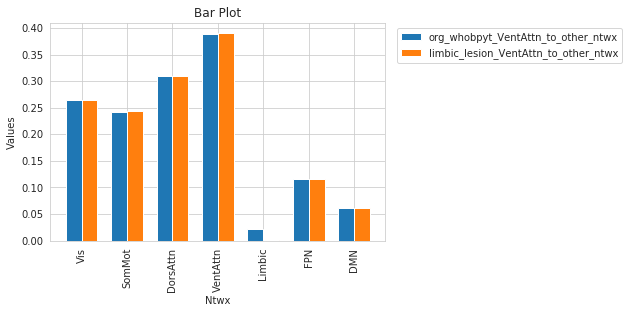

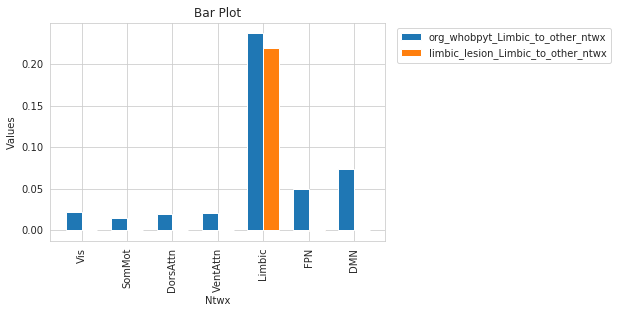

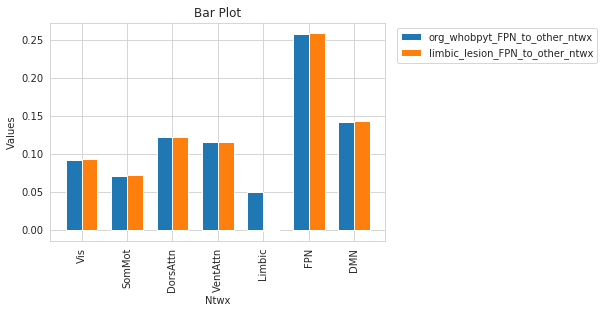

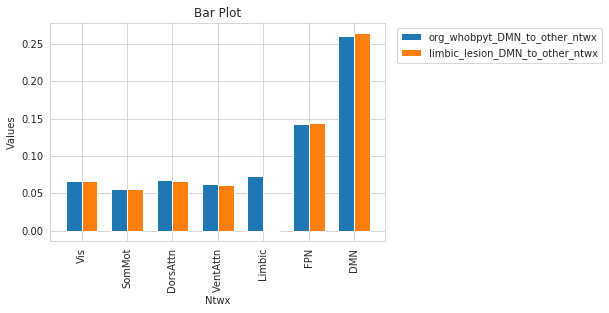

In [356]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], limbic_lesion_outer_to_other_ntwx[j], width, label='limbic_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### FPN

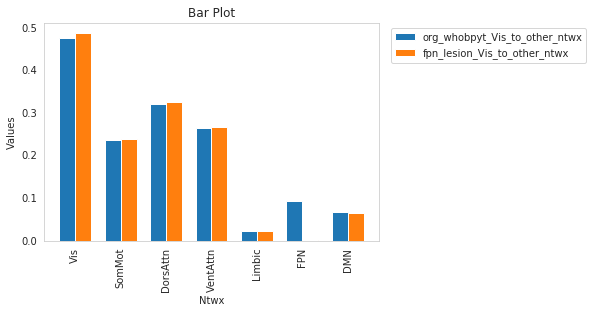

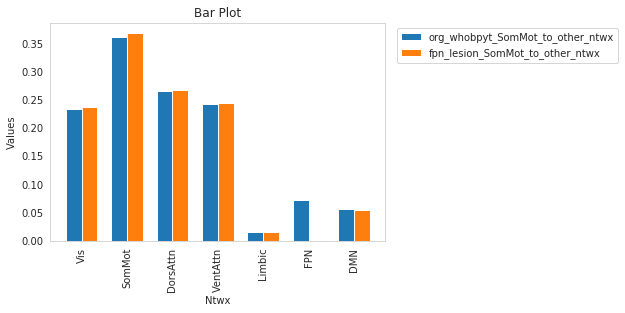

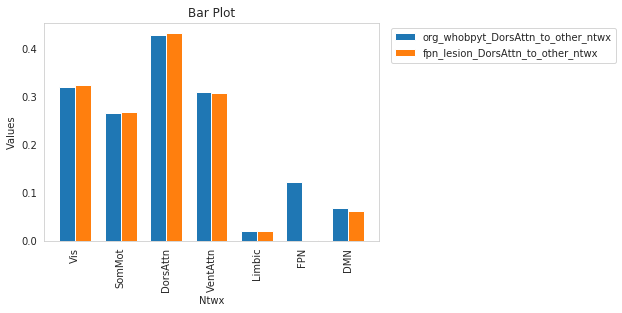

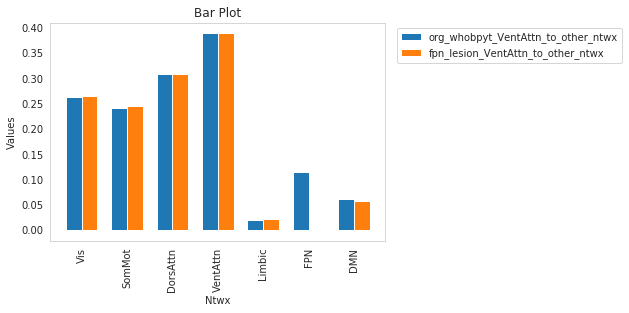

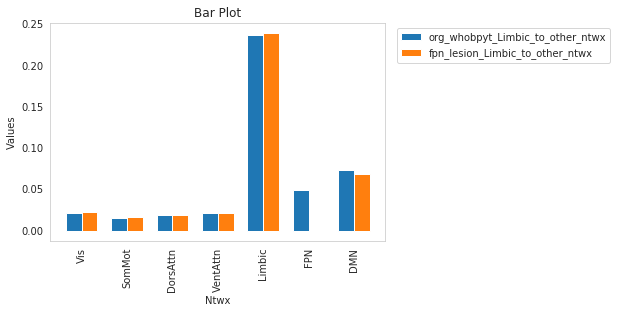

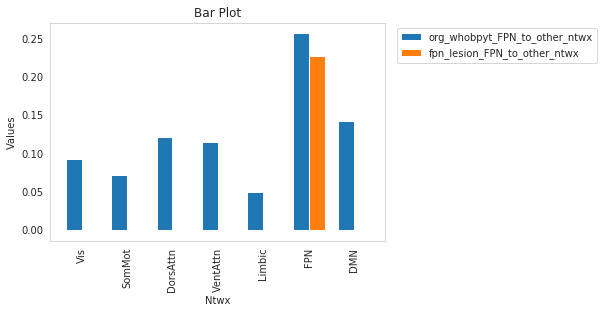

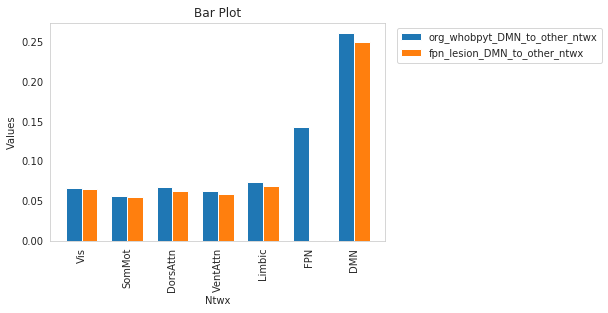

In [357]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], fpn_lesion_outer_to_other_ntwx[j], width, label='fpn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    plt.grid(False)
    
    # Displaying the plot
    plt.show()

#### DMN

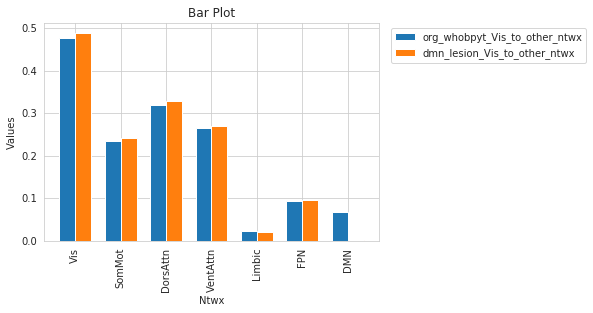

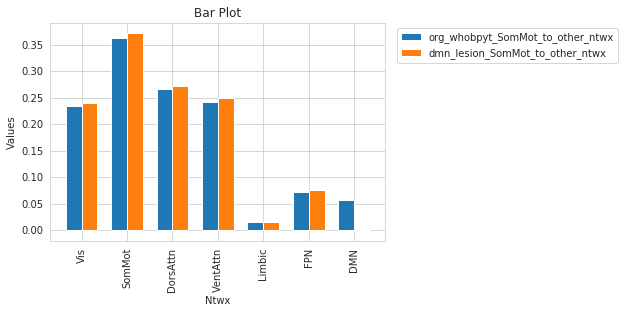

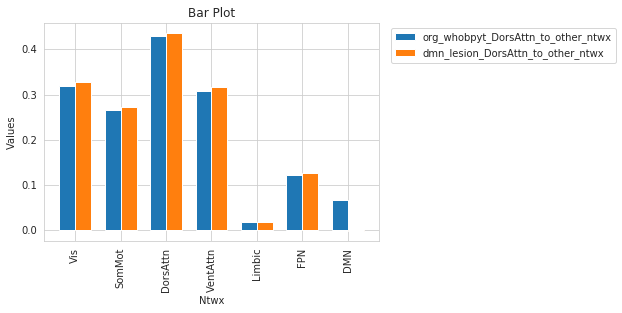

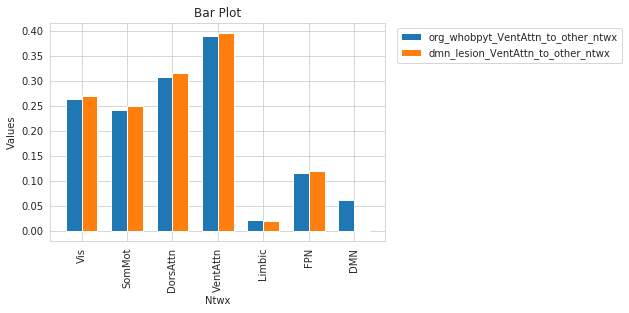

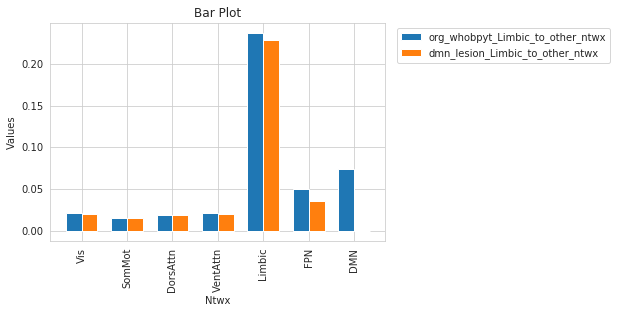

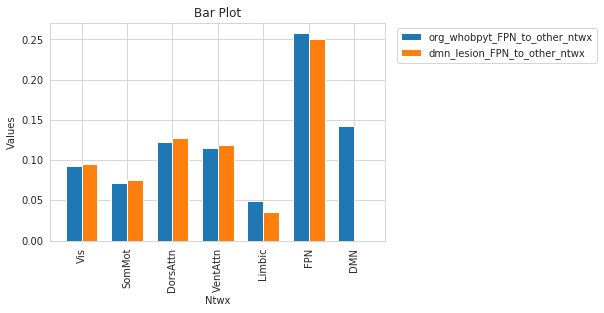

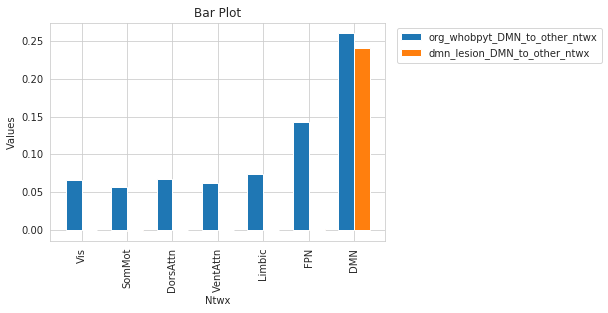

In [358]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dmn_lesion_outer_to_other_ntwx[j], width, label='dmn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

In [359]:
print(og_whobpyt_outer_to_other_ntwx[6])
print(dmn_lesion_outer_to_other_ntwx[6])

[0.06632744219515917, 0.056098499522005706, 0.06769077653437607, 0.06197428368536091, 0.07339070079829807, 0.14251266026333262, 0.2609094925186769]
[0.00021632063232531785, -0.0012219763536731345, -0.0007077312227832381, -6.872025380525073e-05, -0.00012518171436330184, 0.0007512473613598831, 0.24088748638655652]


### --------------------------------------------------------------------------------------------------------------------------------------------------------------

## Stats

In [360]:
Ntwx_labels

['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

In [361]:
# def stats_ttest_func(list1, list2):
    
#     t_statistic, p_value = stats.ttest_ind(list1, list2)
    
#     # Print the results
# #     print('Network = ', Ntwx_labels[i])
#     print("T-Statistic:", t_statistic)
#     print("P-Value:", p_value)
#     print('-------------------', '\n')

In [362]:
# t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[0], vis_lesion_all_subs_outer_to_other_ntwx[0])

# print(t_stat)

# print(p_val)

### `vis` Lesion Stats

In [363]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[i], vis_lesion_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[ 2.19181228 23.57447802 35.14123558 29.2210822  10.12685623 16.00435483
 13.94058142]
[2.89717801e-002 1.53793838e-077 4.56533328e-124 4.43236299e-101
 1.34273358e-021 7.27771612e-045 2.99676190e-036]
['0.0289717801', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
--------------------- 

SomMot to other ntwx stats 

[23.57447802  2.56678105  4.34760703  3.68278364  1.41562614  2.08297236
  3.16089124]
[1.53793838e-77 1.06294666e-02 1.75018745e-05 2.62559151e-04
 1.57667027e-01 3.78915904e-02 1.69322740e-03]
['0.0000000000', '0.0106294666', '0.0000175019', '0.0002625592', '0.1576670275', '0.0378915904', '0.0016932274']
--------------------- 

DorsAttn to other ntwx stats 

[35.14123558  4.34760703  6.0554033   5.48282516  1.84050523  2.35845633
  3.40971695]
[4.56533328e-124 1.75018745e-005 3.24306547e-009 7.44998332e-008
 6.64383779e-002 1.88338307e-002 7.16772166e-004]
['0.0000000000', '0.0000175019', '0.00000

### `smt` Lesion Stats

In [364]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[i], smt_lesion_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-0.72297164 23.44592503  0.56277484  0.63134902  0.23192442  0.22964489
  0.67161919]
[4.70121942e-01 5.46261107e-77 5.73905076e-01 5.28174759e-01
 8.16715913e-01 8.18485692e-01 5.02215797e-01]
['0.4701219418', '0.0000000000', '0.5739050760', '0.5281747591', '0.8167159131', '0.8184856925', '0.5022157973']
--------------------- 

SomMot to other ntwx stats 

[23.44592503  7.65027901 28.0798874  30.3599129   8.31108374 14.36288023
 12.62735418]
[5.46261107e-077 1.52628271e-013 1.94453631e-096 1.20162893e-105
 1.51241944e-015 5.51568915e-038 5.65703630e-031]
['0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
--------------------- 

DorsAttn to other ntwx stats 

[ 0.56277484 28.0798874   1.39441442  1.41828409  0.1353342   0.28351421
  0.85709286]
[5.73905076e-01 1.94453631e-96 1.63970353e-01 1.56890355e-01
 8.92416063e-01 7.76930109e-01 3.91909350e-01]
['0.5739050760', '0.0000000000', '0.1639703530',

### `dan` Lesion Stats

In [365]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[i], dan_lesion_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[ 3.30639723  3.53003704 34.98393465  4.09152726  1.00116929  2.8715641
  2.03273886]
[1.03085895e-003 4.64088107e-004 1.76096150e-123 5.18954677e-005
 3.17353266e-001 4.30281068e-003 4.27422135e-002]
['0.0010308589', '0.0004640881', '0.0000000000', '0.0000518955', '0.3173532655', '0.0043028107', '0.0427422135']
--------------------- 

SomMot to other ntwx stats 

[ 3.53003704  2.67315911 28.21876782  3.46909525  0.17851442  2.89868296
  2.01738018]
[4.64088107e-04 7.82318447e-03 5.25344531e-97 5.79279431e-04
 8.58409829e-01 3.95474567e-03 4.43266426e-02]
['0.0004640881', '0.0078231845', '0.0000000000', '0.0005792794', '0.8584098295', '0.0039547457', '0.0443266426']
--------------------- 

DorsAttn to other ntwx stats 

[34.98393465 28.21876782 10.65346055 40.99514264  9.21343175 21.15119693
 14.92589163]
[1.76096150e-123 5.25344531e-097 1.74588738e-023 6.13576028e-145
 1.84371213e-018 4.29581965e-067 2.53600597e-040]
['0.0000000000', '0.0000000000', '0.000000

### `van` Lesion Stats

In [366]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[i], van_lesion_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-0.20906188  1.15622487  1.1144384  29.15787978  0.57594969  1.00129724
  0.39809099]
[8.34506893e-001 2.48282749e-001 2.65763675e-001 7.98052292e-101
 5.64974709e-001 3.17291499e-001 6.90776564e-001]
['0.8345068934', '0.2482827486', '0.2657636752', '0.0000000000', '0.5649747092', '0.3172914989', '0.6907765644']
--------------------- 

SomMot to other ntwx stats 

[ 1.15622487  1.38070338  2.37359485 30.37560377  0.57354241  1.77124641
  0.70510063]
[2.48282749e-001 1.68145033e-001 1.80897859e-002 1.04068002e-105
 5.66601426e-001 7.72849600e-002 4.81160048e-001]
['0.2482827486', '0.1681450327', '0.0180897859', '0.0000000000', '0.5666014259', '0.0772849600', '0.4811600483']
--------------------- 

DorsAttn to other ntwx stats 

[ 1.1144384   2.37359485  2.81748168 40.97221739  0.63171888  1.74410674
  0.76592088]
[2.65763675e-001 1.80897859e-002 5.08144251e-003 7.34650122e-145
 5.27933261e-001 8.19124995e-002 4.44177378e-001]
['0.2657636752', '0.0180897859', '

### `lim` Lesion Stats

In [367]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[i], lim_lesion_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-8.80526740e-02 -6.88696248e-03 -8.77320782e-02  3.13980447e-02
  9.23576632e+00 -1.19246365e-01  6.66325297e-02]
[9.29879098e-01 9.94508493e-01 9.30133747e-01 9.74967839e-01
 1.55286649e-18 9.05140341e-01 9.46907707e-01]
['0.9298790975', '0.9945084930', '0.9301337474', '0.9749678395', '0.0000000000', '0.9051403406', '0.9469077068']
--------------------- 

SomMot to other ntwx stats 

[-6.88696248e-03 -3.21815668e-01 -1.10922218e-01 -1.87466904e-01
  7.76216749e+00 -1.21170302e-01  4.17587874e-02]
[9.94508493e-01 7.47761297e-01 9.11733940e-01 8.51390103e-01
 7.12032801e-14 9.03617297e-01 9.66711930e-01]
['0.9945084930', '0.7477612968', '0.9117339402', '0.8513901028', '0.0000000000', '0.9036172966', '0.9667119296']
--------------------- 

DorsAttn to other ntwx stats 

[-0.08773208 -0.11092222 -0.02069988 -0.06008111  9.06634927 -0.03496252
  0.19808696]
[9.30133747e-01 9.11733940e-01 9.83495438e-01 9.52121194e-01
 5.67354525e-18 9.72127159e-01 8.43078160e-01]

### `fpn` Lesion Stats

In [368]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[i], fpn_lesion_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-1.12272516 -0.236021   -0.37188177 -0.18722511 -0.4978222  16.14907705
  0.22940829]
[2.62231055e-01 8.13537786e-01 7.10178788e-01 8.51579543e-01
 6.18884311e-01 1.76618712e-45 8.18669439e-01]
['0.2622310553', '0.8135377864', '0.7101787882', '0.8515795429', '0.6188843111', '0.0000000000', '0.8186694395']
--------------------- 

SomMot to other ntwx stats 

[-0.236021   -0.50107613 -0.17330331 -0.25258207 -0.36530688 14.62835596
  0.29263488]
[8.13537786e-01 6.16594558e-01 8.62501125e-01 8.00721579e-01
 7.15076400e-01 4.39223584e-39 7.69953745e-01]
['0.8135377864', '0.6165945578', '0.8625011249', '0.8007215788', '0.7150763995', '0.0000000000', '0.7699537452']
--------------------- 

DorsAttn to other ntwx stats 

[-0.37188177 -0.17330331 -0.24422471  0.04194835  0.02170137 20.92303775
  0.82692723]
[7.10178788e-01 8.62501125e-01 8.07182637e-01 9.66560908e-01
 9.82697049e-01 4.19047647e-66 4.08773797e-01]
['0.7101787882', '0.8625011249', '0.8071826369', '0.966

### `dmn` Lesion Stats

In [369]:
for i in range(7):
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    t_stat, p_val = stats.ttest_ind(og_whobpyt_all_subs_outer_to_other_ntwx[i], dmn_lesion_all_subs_outer_to_other_ntwx[i])
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    
    print(p_val)
    print(p_val_formatted)
    
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-1.28108452 -0.39833612 -0.64982333 -0.49193255  0.43426202 -0.3967065
 14.11673527]
[2.00909925e-01 6.90596039e-01 5.16181219e-01 6.23038240e-01
 6.64333507e-01 6.91796528e-01 5.68765800e-37]
['0.2009099253', '0.6905960387', '0.5161812194', '0.6230382400', '0.6643335066', '0.6917965285', '0.0000000000']
--------------------- 

SomMot to other ntwx stats 

[-0.39833612 -0.74046836 -0.47327576 -0.56972497  0.25364972 -0.49550829
 13.04383725]
[6.90596039e-01 4.59452447e-01 6.36275925e-01 5.69185674e-01
 7.99897155e-01 6.20514849e-01 1.26153995e-32]
['0.6905960387', '0.4594524470', '0.6362759252', '0.5691856738', '0.7998971553', '0.6205148493', '0.0000000000']
--------------------- 

DorsAttn to other ntwx stats 

[-0.64982333 -0.47327576 -0.6419175  -0.65462547  0.18311415 -0.62845352
 15.1351405 ]
[5.16181219e-01 6.36275925e-01 5.21296285e-01 5.13087041e-01
 8.54801695e-01 5.30067363e-01 3.38090323e-41]
['0.5161812194', '0.6362759252', '0.5212962852', '0.5130